# Project Data Science

This dataset contains information on job candidates applying for data science roles. It includes demographic details, education background, work experience, and training hours. The target variable indicates whether a candidate is looking for a new job (1) or not (0).

### Hypothesis  "Higher Experience Leads to Higher Job Seeking Rate"
                "Candidates from Developed Cities Have More Job Opportunities"
                "STEM Majors Are More Likely to Get Jobs"
                "More Training Hours Improve Job Chances"
                "Company Type Affects Job Seeking Rate"

### Stakeholder: Alex Wagner
Role: Job Market Analyst
Background:
Alex Wagner is a data-driven recruitment strategist working in the tech industry. He is responsible for analyzing job market trends, identifying skill gaps, and providing insights into hiring patterns. With years of experience in HR analytics, he wants to understand how factors like education, experience, and training hours impact job-seeking success.
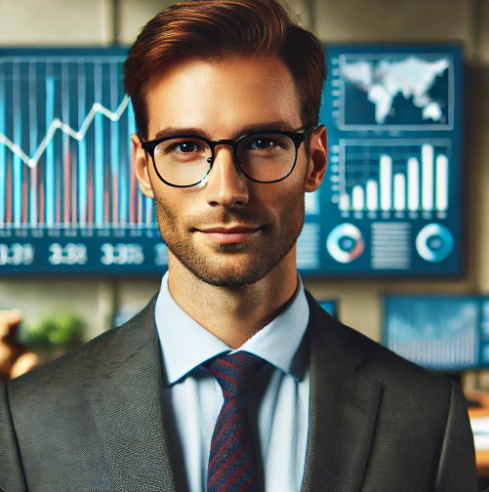

In [1]:
# Load the libraries
%pip install scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

Note: you may need to restart the kernel to use updated packages.


In [2]:
# load the data
df = pd.read_csv('./data/data_science_job.csv')

In [3]:
# Display first few rows
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,52.0,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,20.0,50-99,Funded Startup,8.0,0.0


In [4]:
# Check basic information
df.info()

# Check for missing values
df.isnull().sum()

# Check unique values in categorical columns
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   21
company_size                  8
company_type                  6
training_hours              241
target                        2
dtype: int64

In [5]:
# Drop the columns
df.gender.unique()


array(['Male', nan, 'Female', 'Other'], dtype=object)

In [6]:
# Drop the columns
df.gender.value_counts()["Other"]

np.int64(191)

In [7]:
df = df[df["gender"]!="Other"]

### Convert categorical columns to numerical values

In [8]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['relevent_experience'] = df['relevent_experience'].map({'Has relevent experience': 1, 'No relevent experience': 0})

##  Data Cleaning
### Handling missing values and incorrect formats.

In [9]:
# Fill missing categorical values with "Unknown"
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# Fill missing numerical values with median
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Confirm changes
df.isnull().sum()


enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
training_hours            0
target                    0
dtype: int64

## Exploratory Data Analysis (EDA)


### 1.Gender Distribution

C:\Users\gulca\AppData\Local\Temp\ipykernel_14736\116997873.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, palette="viridis")


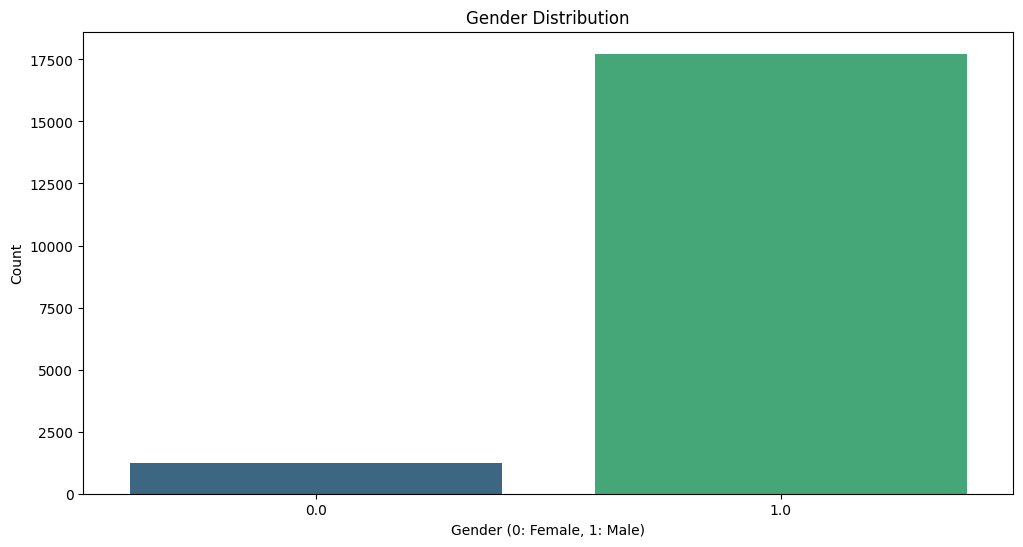

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='gender', data=df, palette="viridis")
plt.title("Gender Distribution")
plt.xlabel("Gender (0: Female, 1: Male)")
plt.ylabel("Count")
plt.show()

### 2. Education Level Distribution

C:\Users\gulca\AppData\Local\Temp\ipykernel_14736\2420632074.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='education_level', data=df, palette="coolwarm", order=df['education_level'].value_counts().index)


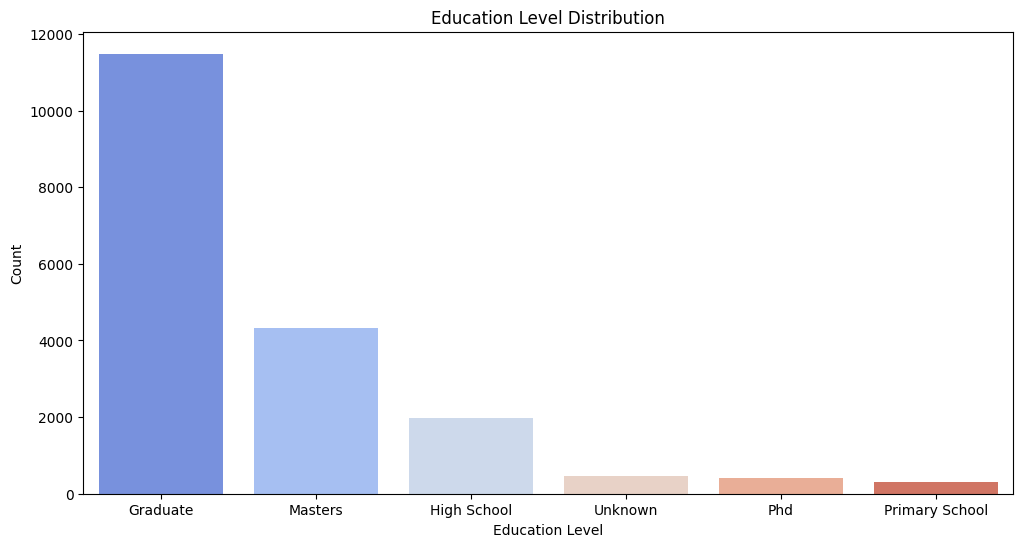

In [11]:
plt.figure(figsize=(12, 6))
sns.countplot(x='education_level', data=df, palette="coolwarm", order=df['education_level'].value_counts().index)
plt.title("Education Level Distribution")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.show()

### 3. Company Size Distribution

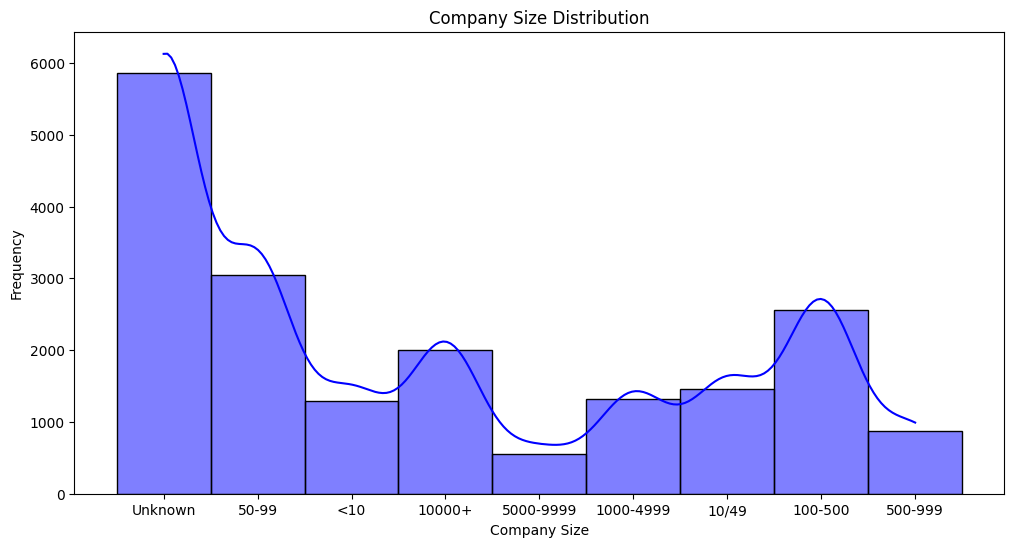

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(df['company_size'], bins=15, kde=True, color='blue')
plt.title("Company Size Distribution")
plt.xlabel("Company Size")
plt.ylabel("Frequency")
plt.show()

### 4. Experience Years Distribution

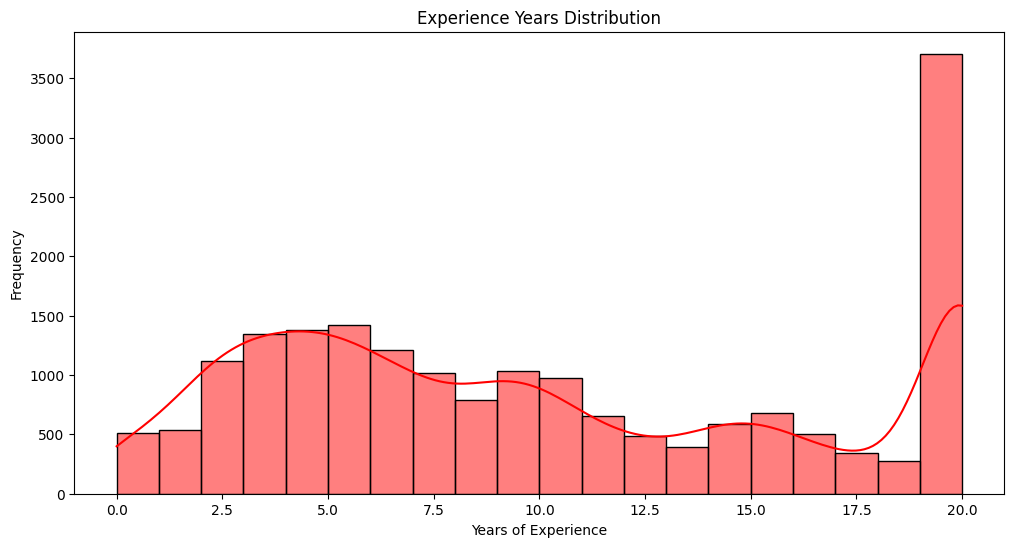

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df['experience'], bins=20, kde=True, color='red')
plt.title("Experience Years Distribution")
plt.xlabel("Years of Experience")
plt.ylabel("Frequency")
plt.show()

### 5. Job Seekers by Education Level

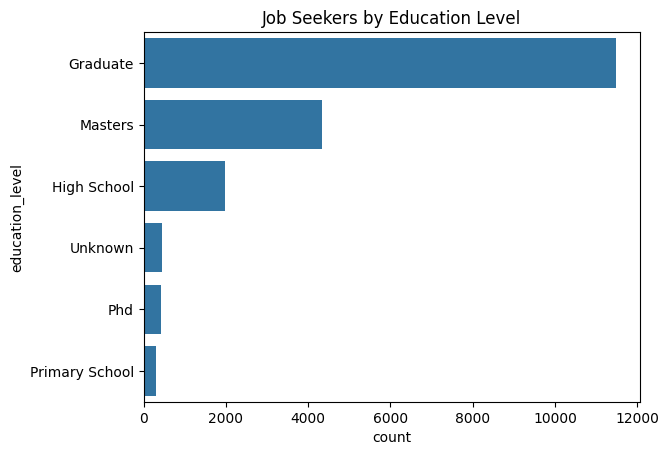

In [14]:
# Job Seekers by Education Level
sns.countplot(data=df, y="education_level", order=df["education_level"].value_counts().index)
plt.title("Job Seekers by Education Level")
plt.show()

### 6. Relationship Between Company Size and Experience

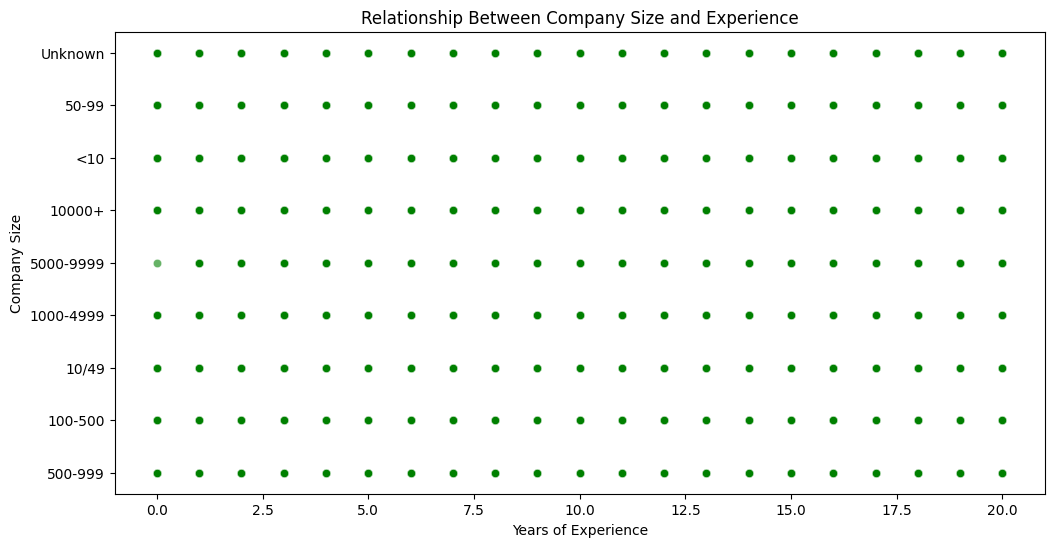

In [15]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='experience', y='company_size', data=df, alpha=0.6, color='green')
plt.title("Relationship Between Company Size and Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Company Size")
plt.show()

### 7. Relationship Between Education Level and Experience

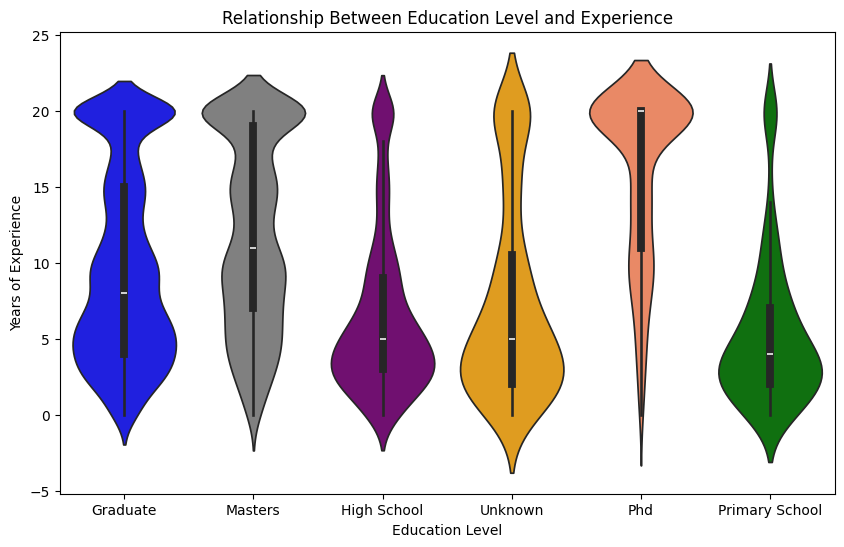

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df, 
    x="education_level", 
    y="experience", 
    hue="education_level",  # Assign hue to education level to match colors correctly
    split=False,  
    palette={"Graduate": "blue", "Masters": "grey", "Phd": "coral", "Primary School": "green", "High School": "purple", "Unknown": "orange"},
    legend=False  # Hide duplicate legends
)

# Add title and labels
plt.title("Relationship Between Education Level and Experience")
plt.xlabel("Education Level")
plt.ylabel("Years of Experience")

plt.show()


### 8. Job Seeking and Experience Relationship

C:\Users\gulca\AppData\Local\Temp\ipykernel_14736\956028379.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='experience', data=df, palette="plasma")


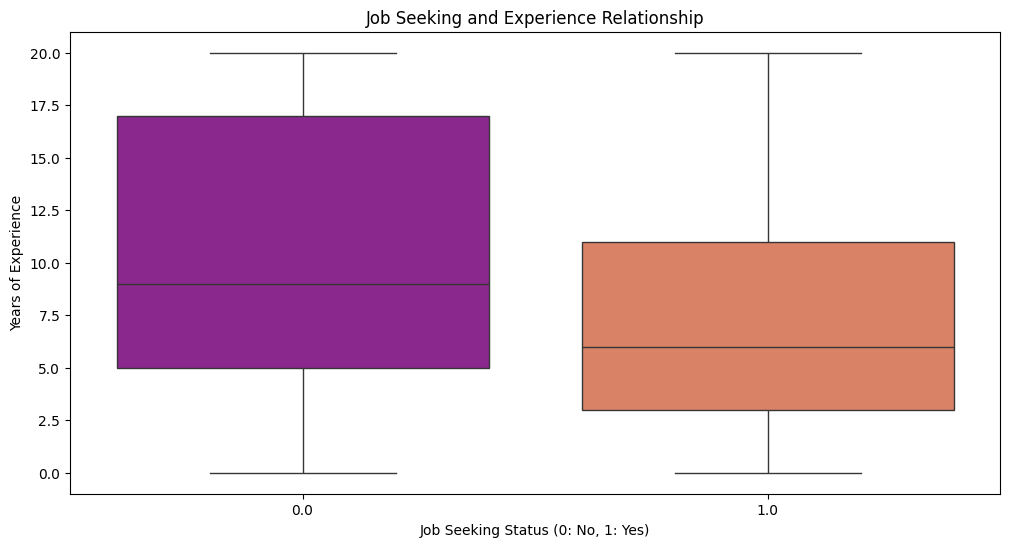

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='experience', data=df, palette="plasma")
plt.title("Job Seeking and Experience Relationship")
plt.xlabel("Job Seeking Status (0: No, 1: Yes)")
plt.ylabel("Years of Experience")
plt.show()

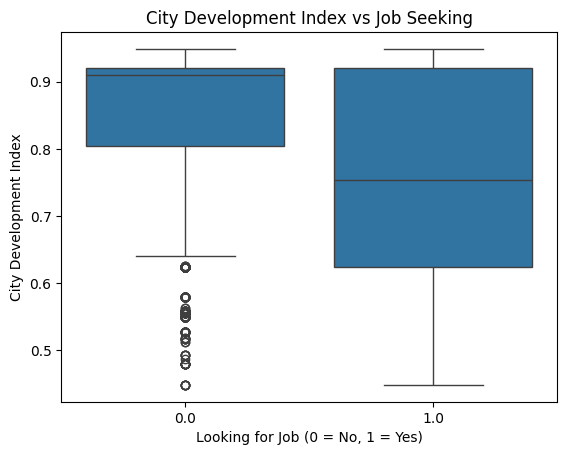

In [66]:
# City Development Index vs. Job Seeking
sns.boxplot(data=df, x="target", y="city_development_index")
plt.title("City Development Index vs Job Seeking")
plt.xlabel("Looking for Job (0 = No, 1 = Yes)")
plt.ylabel("City Development Index")
plt.show()

### Convert company_size using log transformation and scaling

In [18]:
company_size_mapping = {
    '<10': 5,
    '10-49': 30,
    '50-99': 75,
    '100-500': 300,
    '500-999': 750,
    '1000-4999': 3000,
    '5000-9999': 7500,
    '10000+': 15000
}
df['company_size'] = df['company_size'].map(company_size_mapping)

### Apply log transformation

In [21]:
df['company_size'] = np.log1p(df['company_size'])

### Scale company_size to 0-1 range

In [23]:
from sklearn.preprocessing import MinMaxScaler  # ✅ Import the missing library

# Initialize scaler
scaler = MinMaxScaler()

# Apply scaling to the 'company_size' column
df[['company_size']] = scaler.fit_transform(df[['company_size']])

# Check the result
print(df[['company_size']].head())


   company_size
0           NaN
1      0.484261
2           NaN
3           NaN
4      0.484261


### Handle missing values

In [25]:
from sklearn.impute import SimpleImputer  # ✅ Import the missing library

# Initialize imputer with the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation to the dataset
df[:] = imputer.fit_transform(df)

# Check if missing values are handled
print(df.isnull().sum())  # Should print 0 for all columns


enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
training_hours            0
target                    0
dtype: int64


### Encode categorical variables

In [27]:
from sklearn.preprocessing import LabelEncoder

# Define categorical columns
categorical_columns = ['city', 'enrolled_university', 'education_level', 'major_discipline', 'company_type']

# Initialize a dictionary to store encoders
label_encoders = {}

# Apply Label Encoding to each categorical column
for col in categorical_columns:
    le = LabelEncoder()

    # Handle missing values before encoding
    df[col] = df[col].fillna("Unknown")  # Replace NaN with 'Unknown'

    # Fit & transform the column
    df[col] = le.fit_transform(df[col])

    # Store the encoder for later use (e.g., inverse transformation)
    label_encoders[col] = le

# Check the first few rows after encoding
print(df.head())


   enrollee_id  city  city_development_index  gender  relevent_experience  \
0         8949     5                   0.920     1.0                    1   
1        29725    77                   0.776     1.0                    0   
2        11561    64                   0.624     1.0                    0   
3        33241    14                   0.789     1.0                    0   
4          666    50                   0.767     1.0                    1   

   enrolled_university  education_level  major_discipline  experience  \
0                    3                0                 5        20.0   
1                    3                0                 5        15.0   
2                    0                0                 5         5.0   
3                    2                0                 1         0.0   
4                    3                2                 5        20.0   

   company_size  company_type  training_hours  target  
0      0.484261             6            3

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18967 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18967 non-null  int64  
 1   city                    18967 non-null  int64  
 2   city_development_index  18967 non-null  float64
 3   gender                  18967 non-null  float64
 4   relevent_experience     18967 non-null  int64  
 5   enrolled_university     18967 non-null  int64  
 6   education_level         18967 non-null  int64  
 7   major_discipline        18967 non-null  int64  
 8   experience              18967 non-null  float64
 9   company_size            18967 non-null  float64
 10  company_type            18967 non-null  int64  
 11  training_hours          18967 non-null  float64
 12  target                  18967 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 2.5 MB


In [29]:
df.describe()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
count,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000
mean,16864.799652,44.217378,0.830447,0.934729,0.721516,2.269257,0.809037,4.865134,9.934834,0.581853,4.808299,64.464227,0.249222
std,9603.857381,35.428691,0.122511,0.247010,0.448265,1.222524,1.186552,1.051179,6.493288,0.242606,1.492767,58.786029,0.432574
min,1.000000,0.000000,0.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8554.500000,5.000000,0.743000,1.000000,0.000000,1.000000,0.000000,5.000000,4.000000,0.484261,5.000000,24.000000,0.000000
50%,16980.000000,48.000000,0.903000,1.000000,1.000000,3.000000,0.000000,5.000000,9.000000,0.484261,5.000000,47.000000,0.000000
75%,25123.500000,64.000000,0.920000,1.000000,1.000000,3.000000,2.000000,5.000000,16.000000,0.704056,6.000000,86.000000,0.000000
max,33380.000000,122.000000,0.949000,1.000000,1.000000,3.000000,5.000000,6.000000,20.000000,1.000000,6.000000,336.000000,1.000000


In [30]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,8949,5,0.920,1.0,1,3,0,5,20.0,0.484261,6,36.0,1.0
1,29725,77,0.776,1.0,0,3,0,5,15.0,0.484261,5,47.0,0.0
2,11561,64,0.624,1.0,0,0,0,5,5.0,0.484261,6,83.0,0.0
3,33241,14,0.789,1.0,0,2,0,1,0.0,0.484261,5,52.0,1.0
4,666,50,0.767,1.0,1,3,2,5,20.0,0.484261,1,8.0,0.0


Modelling (ML)

In [31]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=537)

### Initialize models

In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron()
}

### Train and evaluate models

In [33]:
import time
from sklearn.metrics import accuracy_score

results = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    accuracy = accuracy_score(y_test, y_pred)
    runtime = end_time - start_time

    results.append((name, accuracy, runtime))

results_table = pd.DataFrame(results, columns=["Model", "Accuracy", "Runtime (seconds)"])

c:\Users\gulca\Documents\greenbootcamps\Data_science_job_data_set\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
results_table

,Model,Accuracy,Runtime (seconds)
0,Random Forest,0.784221,1.546524
1,Logistic Regression,0.756282,0.071868
2,Support Vector Machine,0.755755,3.560001
3,Decision Tree,0.704621,0.067912
4,K-Nearest Neighbors,0.709366,0.123574
5,Naive Bayes,0.728870,0.005005
6,Gradient Boosting,0.787735,1.361895
7,AdaBoost,0.777543,0.331002
8,Ridge Classifier,0.766473,0.018609
9,Perceptron,0.755579,0.009509


### Convert results to DataFrame and sort

In [35]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Runtime'])
results_df['Performance Score'] = results_df['Accuracy'] / results_df['Runtime'] 
results_df = results_df.sort_values(by=['Accuracy', 'Runtime'], ascending=[False, True])

In [36]:
results_df

,Model,Accuracy,Runtime,Performance Score
6,Gradient Boosting,0.787735,1.361895,0.578411
0,Random Forest,0.784221,1.546524,0.507086
7,AdaBoost,0.777543,0.331002,2.349056
8,Ridge Classifier,0.766473,0.018609,41.188212
1,Logistic Regression,0.756282,0.071868,10.523250
2,Support Vector Machine,0.755755,3.560001,0.212291
9,Perceptron,0.755579,0.009509,79.456637
5,Naive Bayes,0.728870,0.005005,145.617937
4,K-Nearest Neighbors,0.709366,0.123574,5.740411
3,Decision Tree,0.704621,0.067912,10.375454


### Visualisation Model Accuracy

C:\Users\gulca\AppData\Local\Temp\ipykernel_14736\105494478.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette="coolwarm")


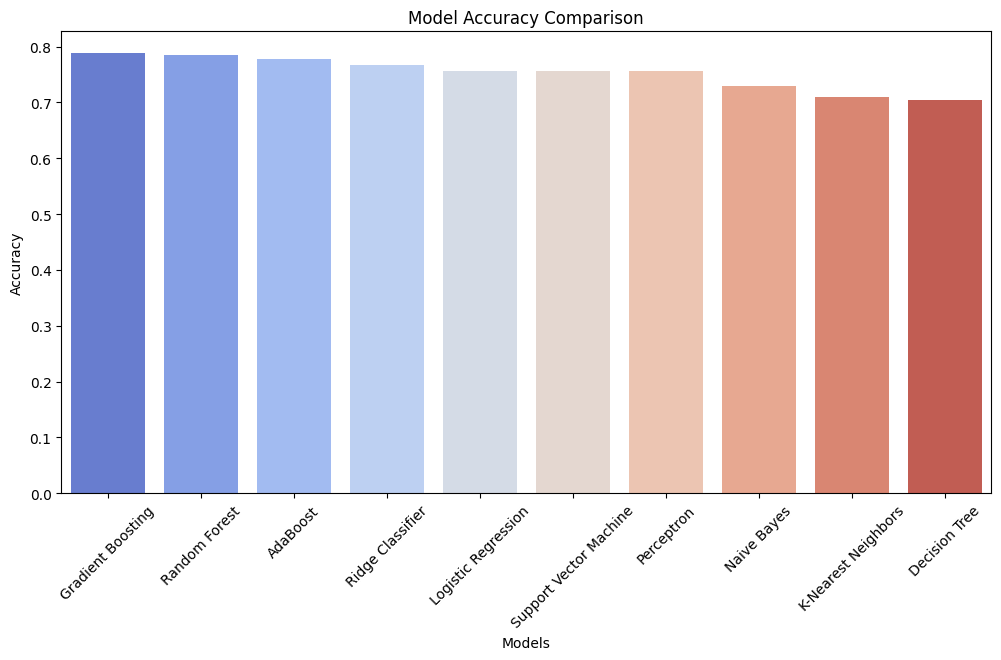

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

### Visualizing Model Runtime

C:\Users\gulca\AppData\Local\Temp\ipykernel_14736\157459943.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Runtime', data=results_df, palette="viridis")


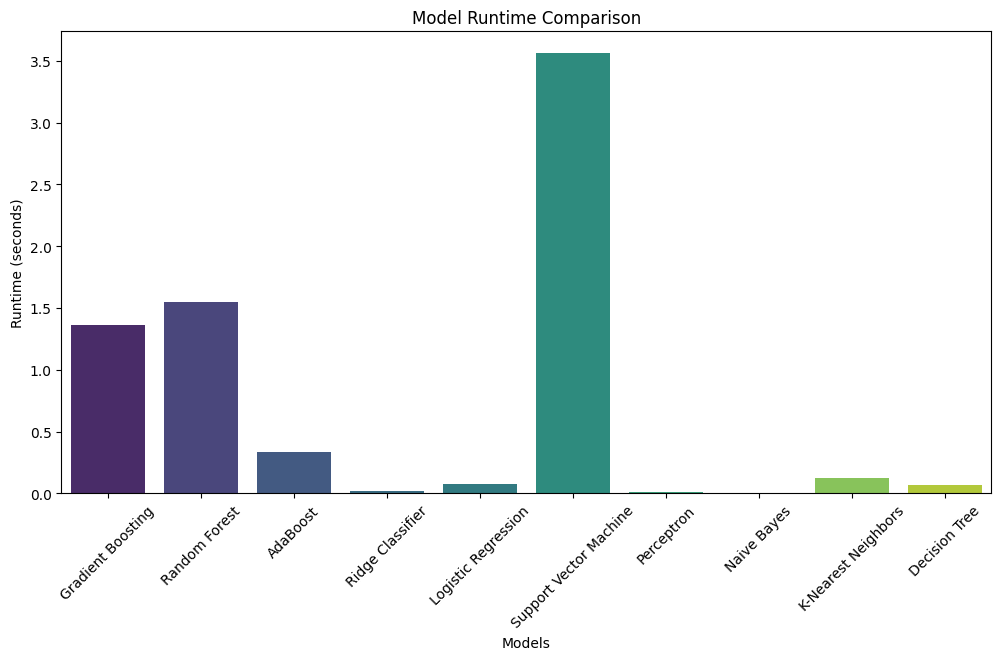

In [38]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Runtime', data=results_df, palette="viridis")
plt.xticks(rotation=45)
plt.title("Model Runtime Comparison")
plt.xlabel("Models")
plt.ylabel("Runtime (seconds)")
plt.show()

### Combined Visualization of Accuracy and Runtime

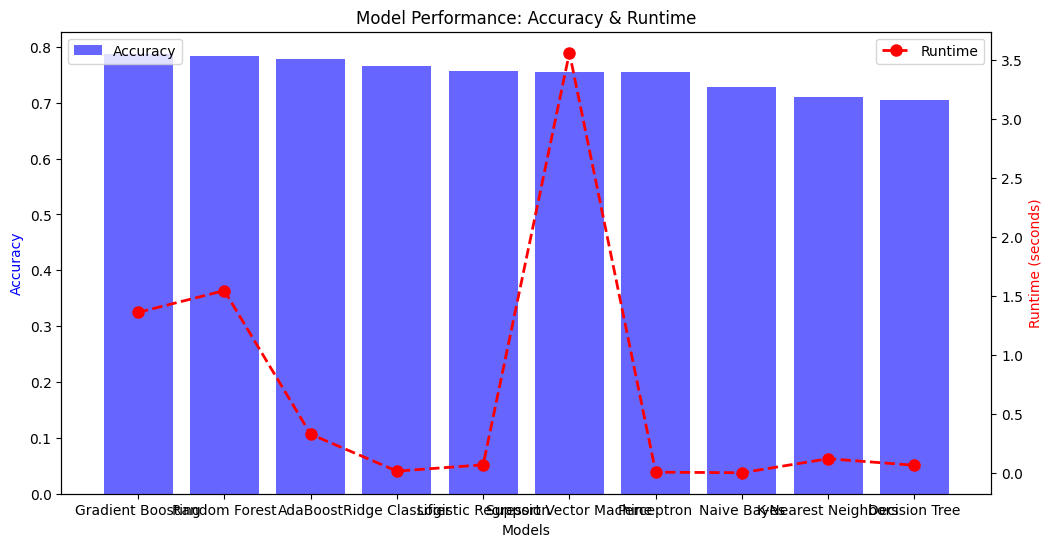

In [39]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.bar(results_df['Model'], results_df['Accuracy'], color='b', alpha=0.6, label="Accuracy")
ax2.plot(results_df['Model'], results_df['Runtime'], color='r', marker='o', linestyle='dashed', linewidth=2, markersize=8, label="Runtime")

ax1.set_xlabel("Models")
ax1.set_ylabel("Accuracy", color='b')
ax2.set_ylabel("Runtime (seconds)", color='r')
plt.xticks(rotation=45)
plt.title("Model Performance: Accuracy & Runtime")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

### Tabular Visualization

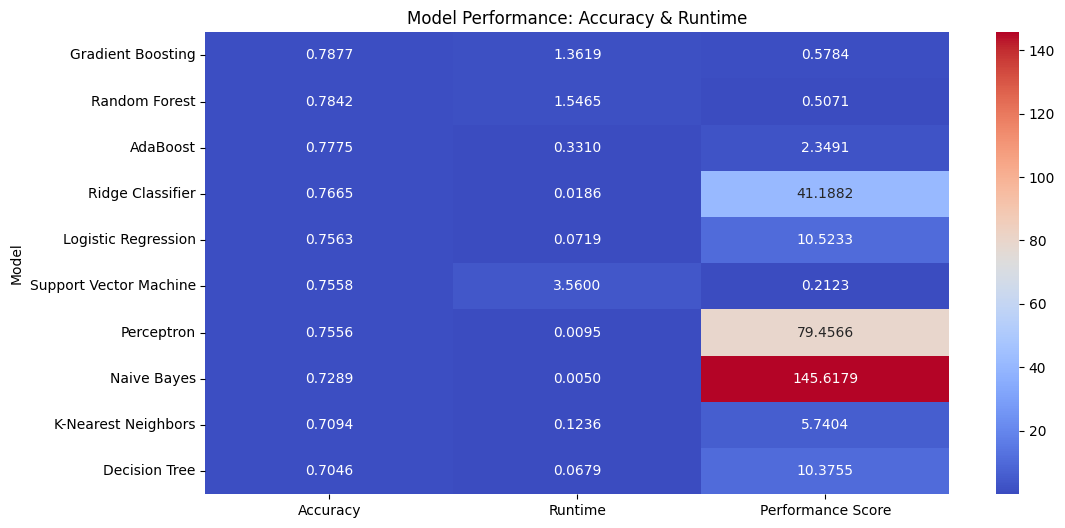

In [40]:
plt.figure(figsize=(12, 6))
sns.heatmap(results_df.set_index('Model'), annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Model Performance: Accuracy & Runtime")
plt.show()

### Modelling (DL)-Deep Learning

### Reshape for deep learning models

In [41]:
X_train_dl = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_dl = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Initialize models
results = []

### Logistic Regression

In [42]:
start_time = time.time()
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, y_pred)
logistic_time = time.time() - start_time
results.append(("Logistic Regression", logistic_accuracy, logistic_time))

c:\Users\gulca\Documents\greenbootcamps\Data_science_job_data_set\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### MLP-Multilayer Perceptron

In [43]:
from sklearn.neural_network import MLPClassifier

start_time = time.time()
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500)
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, y_pred)
mlp_time = time.time() - start_time
results.append(("MLP Neural Network", mlp_accuracy, mlp_time))

### RNN - Recurrent Neural Network

In [44]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Ensure torch uses the correct device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reshape input data to match PyTorch's expected format
X_train_dl = torch.tensor(X_train.values, dtype=torch.float32).reshape((X_train.shape[0], X_train.shape[1], 1)).to(device)
X_test_dl = torch.tensor(X_test.values, dtype=torch.float32).reshape((X_test.shape[0], X_test.shape[1], 1)).to(device)
y_train_dl = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_dl = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Create DataLoader for efficient batching
batch_size = 128
train_dataset = TensorDataset(X_train_dl, y_train_dl)
test_dataset = TensorDataset(X_test_dl, y_test_dl)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the RNN Model in PyTorch
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=3, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.rnn(x)  # RNN returns output and hidden state
        x = self.fc(x[:, -1, :])  # Take the last time-step output
        return torch.sigmoid(x)

# Initialize the Model
input_size = 1  # Since features are reshaped to (batch, seq_len, 1)
hidden_size = 100
output_size = 1

rnn_model = RNNModel(input_size, hidden_size, output_size).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy (like in TensorFlow)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Training Loop
start_time = time.time()

epochs = 10
for epoch in range(epochs):
    rnn_model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = rnn_model(batch_X)
        loss = criterion(predictions.view(-1), batch_y)  # Flatten predictions for loss calculation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
rnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = rnn_model(batch_X)
        predicted = (predictions.view(-1) > 0.5).float()
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

rnn_accuracy = correct / total
rnn_time = time.time() - start_time

# Store Results
results.append(("RNN", rnn_accuracy, rnn_time))

print(f"Test Accuracy: {rnn_accuracy:.4f}")
print(f"Training Time: {rnn_time:.2f} seconds")


Epoch 1/10, Loss: 0.5600
Epoch 2/10, Loss: 0.5462
Epoch 3/10, Loss: 0.5437
Epoch 4/10, Loss: 0.5410
Epoch 5/10, Loss: 0.5379
Epoch 6/10, Loss: 0.5346
Epoch 7/10, Loss: 0.5286
Epoch 8/10, Loss: 0.5279
Epoch 9/10, Loss: 0.5226
Epoch 10/10, Loss: 0.5203
Test Accuracy: 0.7605
Training Time: 16.96 seconds


### LSTM Model - Long Short-Term Memory

In [47]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Ensure PyTorch uses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert Data to PyTorch Tensors
X_train_dl = torch.tensor(X_train.values, dtype=torch.float32).reshape((X_train.shape[0], X_train.shape[1], 1)).to(device)
X_test_dl = torch.tensor(X_test.values, dtype=torch.float32).reshape((X_test.shape[0], X_test.shape[1], 1)).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Create DataLoader for batching
batch_size = 128
train_dataset = TensorDataset(X_train_dl, y_train)
test_dataset = TensorDataset(X_test_dl, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the PyTorch LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM output and hidden state
        x = self.fc(x[:, -1, :])  # Take the last timestep output
        return torch.sigmoid(x)

# Initialize Model
input_size = 1  # Because X is reshaped as (batch, seq_length, 1)
hidden_size = 100
output_size = 1
num_layers = 3

lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss (for classification)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training Loop
start_time = time.time()

epochs = 10
for epoch in range(epochs):
    lstm_model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = lstm_model(batch_X)
        loss = criterion(predictions.view(-1), batch_y)  # Flatten for loss calculation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluate Model
lstm_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = lstm_model(batch_X)
        predicted = (predictions.view(-1) > 0.5).float()
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

lstm_accuracy = correct / total
lstm_time = time.time() - start_time

# Store Results
results.append(("LSTM", lstm_accuracy, lstm_time))

print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")
print(f"Training Time: {lstm_time:.2f} seconds")


Epoch 1/10, Loss: 0.5579
Epoch 2/10, Loss: 0.5365
Epoch 3/10, Loss: 0.5324
Epoch 4/10, Loss: 0.5332
Epoch 5/10, Loss: 0.5191
Epoch 6/10, Loss: 0.5176
Epoch 7/10, Loss: 0.5102
Epoch 8/10, Loss: 0.5082
Epoch 9/10, Loss: 0.5079
Epoch 10/10, Loss: 0.5055
LSTM Test Accuracy: 0.7616
Training Time: 42.49 seconds


### CNN - Convolutional Neural Network

In [58]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Ensure PyTorch uses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🔹 **Fix: Ensure X_train and y_train Have the Same Length**
X_train = X_train.iloc[:len(y_train)]
y_train = y_train.iloc[:len(X_train)]
X_test = X_test.iloc[:len(y_test)]
y_test = y_test.iloc[:len(X_test)]

# Convert Data to PyTorch Tensors
X_train_dl = torch.tensor(X_train.values, dtype=torch.float32).reshape((len(X_train), 1, X_train.shape[1])).to(device)
X_test_dl = torch.tensor(X_test.values, dtype=torch.float32).reshape((len(X_test), 1, X_test.shape[1])).to(device)

# Convert target variables to PyTorch Tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# ✅ Verify Shapes
print(f"✅ X_train shape: {X_train_dl.shape}, X_test shape: {X_test_dl.shape}")
print(f"✅ y_train shape: {y_train_tensor.shape}, y_test shape: {y_test_tensor.shape}")

# Create DataLoader for batching
batch_size = 128
train_dataset = TensorDataset(X_train_dl, y_train_tensor)
test_dataset = TensorDataset(X_test_dl, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 🔹 **Define CNN Model in PyTorch**
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * X_train_dl.shape[2], 100)  # Adjust input size dynamically
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the Model
cnn_model = CNNModel().to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss (for classification)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# 🔹 **Training Loop**
start_time = time.time()

epochs = 10
for epoch in range(epochs):
    cnn_model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        batch_X = batch_X  # No need for permute; it's correctly shaped now
        predictions = cnn_model(batch_X)
        loss = criterion(predictions.view(-1), batch_y.view(-1))  # Ensure correct shape
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# 🔹 **Evaluate Model**
cnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = cnn_model(batch_X)
        predicted = (predictions.view(-1) > 0.5).float()
        correct += (predicted == batch_y.view(-1)).sum().item()
        total += batch_y.size(0)

cnn_accuracy = correct / total
cnn_time = time.time() - start_time

# Store Results
results.append(("CNN", cnn_accuracy, cnn_time))

print(f"🎯 CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"⏱️ Training Time: {cnn_time:.2f} seconds")


✅ X_train shape: torch.Size([13276, 1, 12]), X_test shape: torch.Size([5691, 1, 12])
✅ y_train shape: torch.Size([13276, 1]), y_test shape: torch.Size([5691, 1])
Epoch 1/10, Loss: 56.7072
Epoch 2/10, Loss: 49.1456
Epoch 3/10, Loss: 55.9649
Epoch 4/10, Loss: 74.2057
Epoch 5/10, Loss: 74.5630
Epoch 6/10, Loss: 73.9945
Epoch 7/10, Loss: 74.1161
Epoch 8/10, Loss: 71.7994
Epoch 9/10, Loss: 71.3932
Epoch 10/10, Loss: 74.3590
🎯 CNN Test Accuracy: 0.2539
⏱️ Training Time: 10.40 seconds


### Collect results

In [59]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Training Time (s)"])

Sort results by prioritizing high accuracy and low training time

In [60]:
results_df = results_df.sort_values(by=["Accuracy", "Training Time (s)"], ascending=[False, True])
results_df

,Model,Accuracy,Training Time (s)
3,LSTM,0.761553,42.491423
2,RNN,0.760499,16.958999
0,Logistic Regression,0.756282,0.114811
1,MLP Neural Network,0.755052,8.453949
4,CNN,0.253910,10.404430


### Visualizing Model Accuracy

C:\Users\gulca\AppData\Local\Temp\ipykernel_14736\105494478.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette="coolwarm")


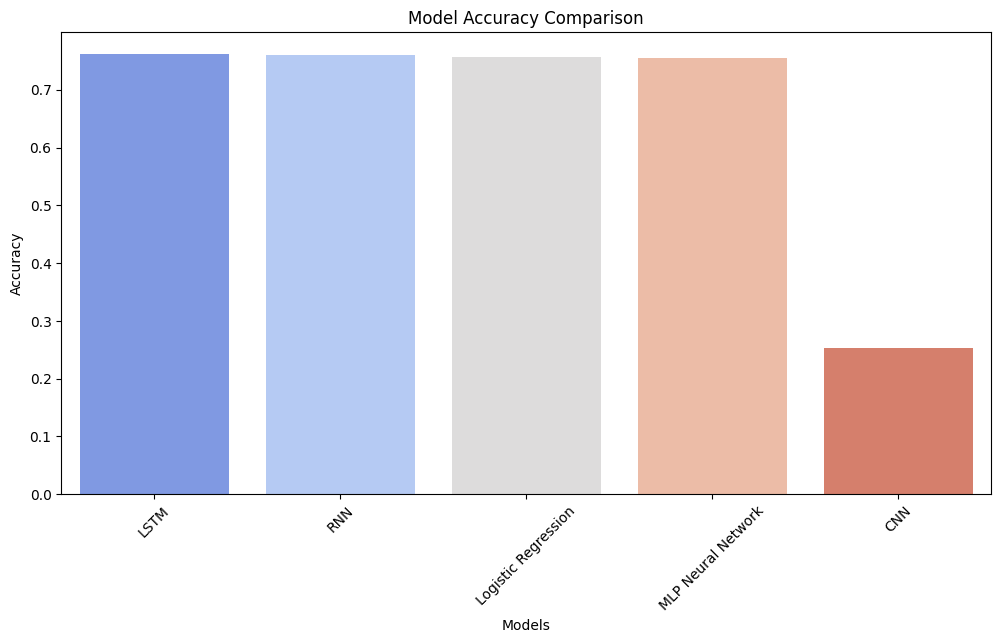

In [61]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

This bar chart compares the **accuracy of different machine learning models**. **LSTM, RNN, Logistic Regression, and MLP Neural Network** achieve similar high accuracy, making them suitable choices for prediction. However, **CNN performs significantly worse**, indicating that it may not be the best model for this dataset.

Visualizing Model Runtime

C:\Users\gulca\AppData\Local\Temp\ipykernel_14736\2531263090.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time (s)', data=results_df, palette="viridis")


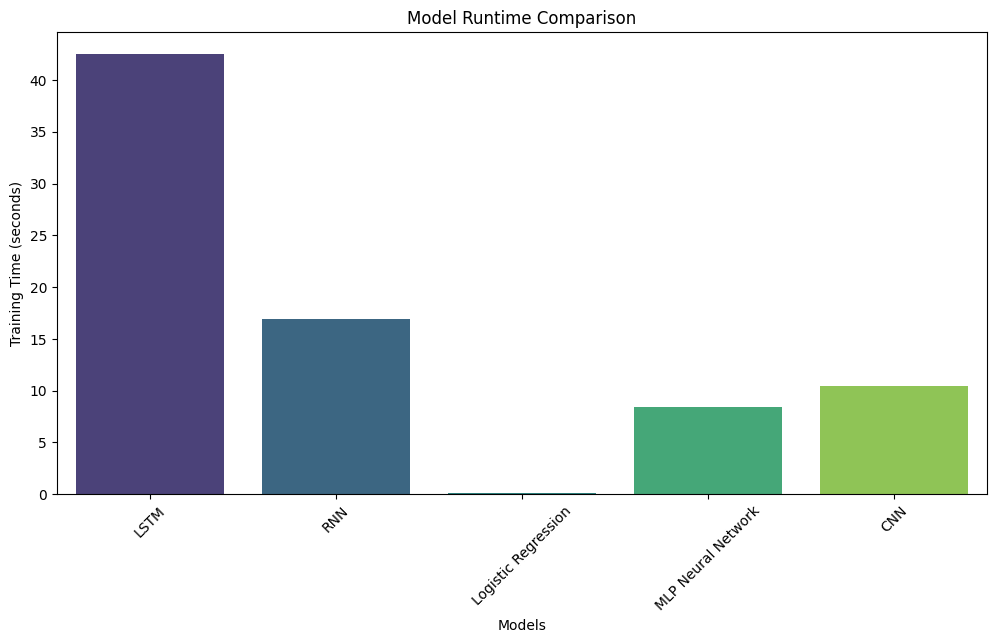

In [62]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Training Time (s)', data=results_df, palette="viridis")
plt.xticks(rotation=45)
plt.title("Model Runtime Comparison")
plt.xlabel("Models")
plt.ylabel("Training Time (seconds)")
plt.show()

This bar chart compares the **training time** of different machine learning models. **LSTM takes the longest time (~42s)** due to its complex sequential processing, while **Logistic Regression is the fastest** with near-instant training. **RNN, CNN, and MLP Neural Network fall in between**, balancing performance and computational efficiency.

### Combined Visualization of Accuracy and Runtime

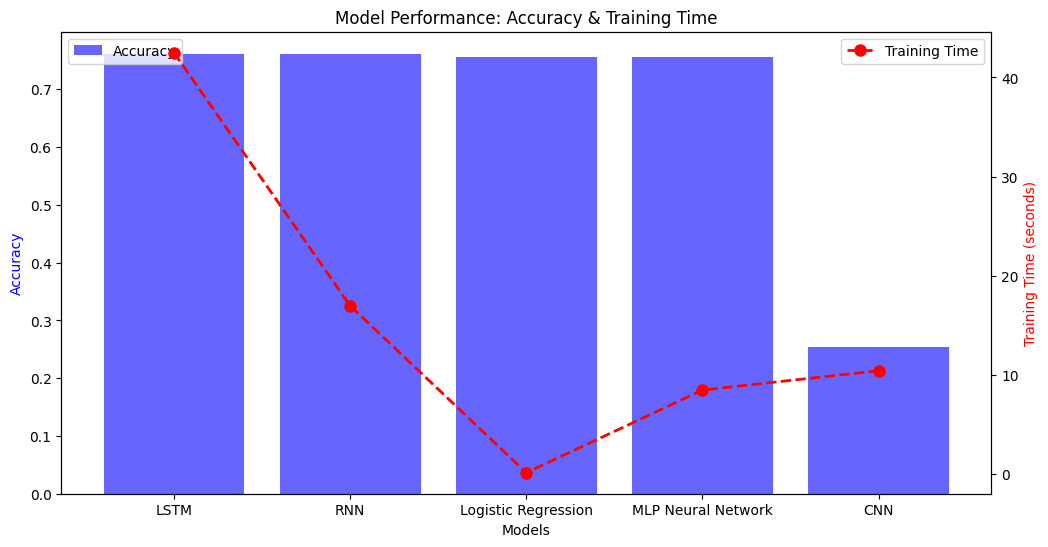

In [63]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.bar(results_df['Model'], results_df['Accuracy'], color='b', alpha=0.6, label="Accuracy")
ax2.plot(results_df['Model'], results_df['Training Time (s)'], color='r', marker='o', linestyle='dashed', linewidth=2, markersize=8, label="Training Time")
ax1.set_xlabel("Models")
ax1.set_ylabel("Accuracy", color='b')
ax2.set_ylabel("Training Time (seconds)", color='r')
plt.xticks(rotation=45)
plt.title("Model Performance: Accuracy & Training Time")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

This visualization compares the **accuracy** and **training time** of different machine learning models. The **LSTM, RNN, and MLP Neural Network models achieve the highest accuracy**, while **Logistic Regression trains the fastest but with lower accuracy**. The **CNN model has the lowest accuracy**, indicating it may not be the best choice for this dataset.

### Tabular Visualization

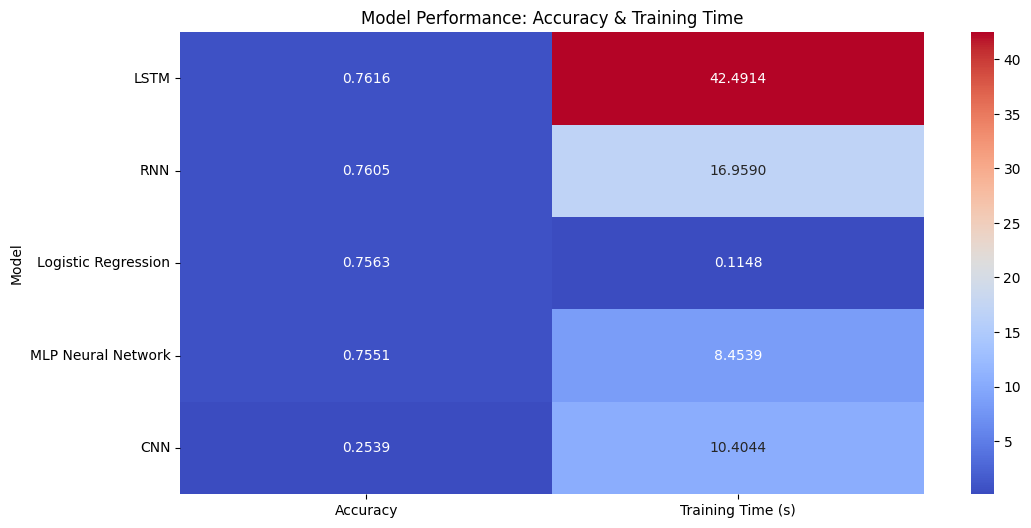

In [64]:
plt.figure(figsize=(12, 6))
sns.heatmap(results_df.set_index('Model'), annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Model Performance: Accuracy & Training Time")
plt.show()

The heatmap compares the accuracy and training time of different machine learning models, showing that LSTM (Long Short-Term Memory) has the highest accuracy (0.7616) but takes the longest training time (42.49s), while Logistic Regression achieves similar accuracy (0.7563) with minimal training time (0.11s), making it more efficient. The CNN model performs the worst in accuracy (0.2539), indicating that it may not be well-suited for this dataset.

### Machine Learning Model - Predicting Job Seeking Status
### I will train a Random Forest Model to predict whether a candidate is looking for a job based on their attributes.

In [67]:
# Prepare the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target variable
X = df.drop(columns=["target", "enrollee_id"])
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Train a Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

if hasattr(model, "feature_importances_"):
    print("Feature importance available")

# Predictions
y_pred = model.predict(X_test)

# Save the trained model
joblib.dump(model, "model.pkl")

print("✅ Model trained and saved successfully as 'model.pkl'")

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Feature importance available
✅ Model trained and saved successfully as 'model.pkl'
Model Accuracy: 0.77


### Model Evaluation

In [69]:
# To understand how well our model performs:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85      2876
         1.0       0.54      0.44      0.48       918

    accuracy                           0.77      3794
   macro avg       0.68      0.66      0.67      3794
weighted avg       0.76      0.77      0.76      3794

[[2524  352]
 [ 513  405]]


### Feature Importance

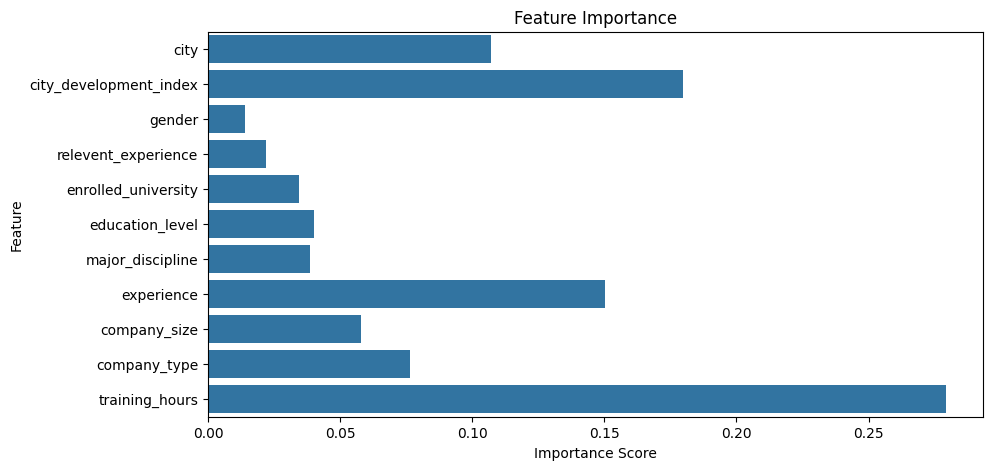

In [74]:
# To see which factors influence job-seeking behavior the most:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

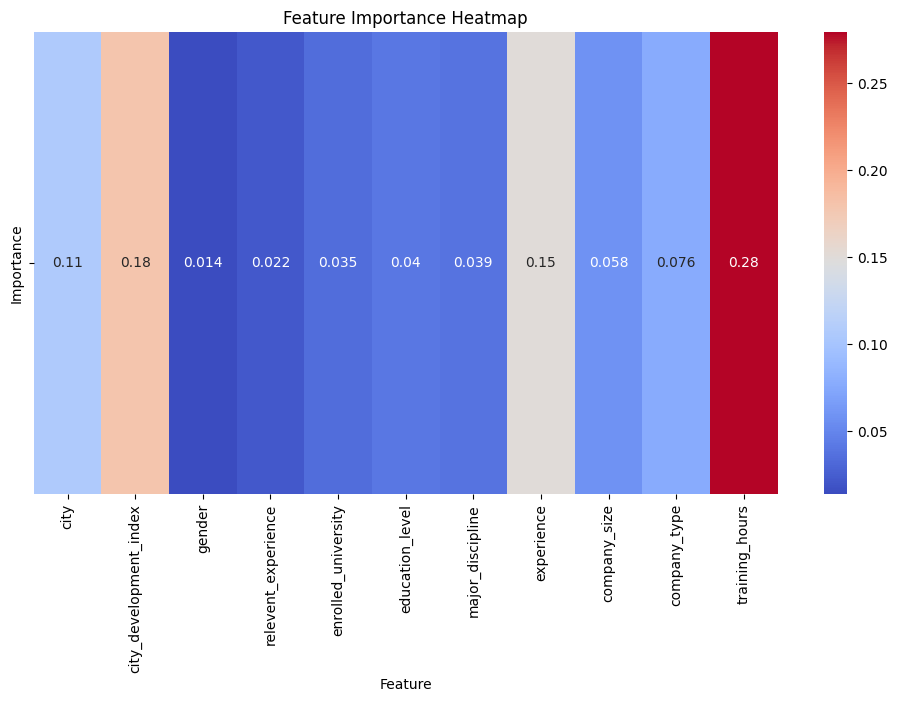

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a heatmap of feature importance
plt.figure(figsize=(12, 6))
sns.heatmap(np.array(importances).reshape(1, -1), annot=True, cmap="coolwarm", xticklabels=feature_names, yticklabels=["Importance"])
plt.title("Feature Importance Heatmap")
plt.xlabel("Feature")
plt.show()

"Through this dataset, we analyzed key factors influencing job-seeking success, including education, experience, and training hours. Using various machine learning models, we identified patterns that help job seekers understand their chances better. With these insights, Alex Wagner can now make data-driven hiring recommendations, ensuring that candidates align well with market demands and skills in high demand."